In [8]:
#forward calculation for pumping (2D)
from scipy.optimize import least_squares
import numpy as np
import scipy
from scipy import special
from numpy.polynomial.hermite import hermfit,hermval
from numpy.polynomial.polynomial import polyfit 
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

def fun_der1(lk1,lk2,r,q,ta,s,t,r0):
    t_len=len(t); r_len=len(r); ini_len=len(r0)
    rcoe=np.zeros((ini_len+2+t_len*(r_len+2),60*4))
    ycoe=np.zeros(ini_len+2+t_len*(r_len+2))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,61):
            if (rk<100.0):
                vk=jk*1.0*np.pi/lk1
                nk=(jk-1)*2
                rk1=rk
            else:
                vk=jk*1.0*np.pi/lk2
                nk=(jk-1)*2+120
                rk1=rk-99.8
            rcoe[ik,nk+0]=scipy.special.jv(0,rk1*vk)
            rcoe[ik,nk+1]=scipy.special.yv(0,rk1*vk)
        ycoe[ik]=52.0
# For the interface in the initial condition
    nk_f=ini_len
    rk=100.0
    for jk in range(1,61):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        rcoe[nk_f,nk+0]=scipy.special.jv(0,rk*vk)
        rcoe[nk_f,nk+1]=scipy.special.yv(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+120
        rk1=rk-99.8
        rcoe[nk_f,nk+0]=-scipy.special.jv(0,rk1*vk)
        rcoe[nk_f,nk+1]=-scipy.special.yv(0,rk1*vk)
    ycoe[nk_f]=0.0
    nk_f=nk_f+1    
    
    for jk in range(1,61):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        rcoe[nk_f,nk+0]=vk*scipy.special.jvp(0,rk*vk)
        rcoe[nk_f,nk+1]=vk*scipy.special.yvp(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+120
        rk1=rk-99.8
        rcoe[nk_f,nk+0]=-vk*scipy.special.jvp(0,rk1*vk)
        rcoe[nk_f,nk+1]=-vk*scipy.special.yvp(0,rk1*vk)
    ycoe[nk_f]=0.0
    nk_f=nk_f+1
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jvp(0,rk*vk)*vk
            rcoe[nk_f,nk+1]=t_term*scipy.special.yvp(0,rk*vk)*vk
        ycoe[nk_f]=+q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-99.8
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+120
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
        ycoe[nk_f]=52.0
        nk_f=nk_f+1
    
# For interface
        rk=100.0
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+120
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=-t_term*scipy.special.jv(0,rk1*vk)
            rcoe[nk_f,nk+1]=-t_term*scipy.special.yv(0,rk1*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
        
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*vk*scipy.special.jvp(0,rk*vk)
            rcoe[nk_f,nk+1]=t_term*vk*scipy.special.yvp(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+120
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            rcoe[nk_f,nk+0]=-t_term*vk*scipy.special.jvp(0,rk1*vk)
            rcoe[nk_f,nk+1]=-t_term*vk*scipy.special.yvp(0,rk1*vk)
        ycoe[nk_f]=0.0
        nk_f=nk_f+1
            
    ck=np.linalg.lstsq(rcoe,ycoe,rcond=None)[0]
    
# Calculate the residual
    resk1=np.zeros(ini_len+2+t_len*(r_len+2))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,61):
            if (rk<100.0):
                vk=jk*1.0*np.pi/lk1
                nk=(jk-1)*2
                rk1=rk
            else:
                vk=jk*1.0*np.pi/lk2
                nk=(jk-1)*2+120
                rk1=rk-99.8
            resk1[ik]=resk1[ik]+ck[nk+0]*scipy.special.jv(0,rk1*vk)
            resk1[ik]=resk1[ik]+ck[nk+1]*scipy.special.yv(0,rk1*vk)
        resk1[ik]=resk1[ik]-52.0
# For the interface in the initial condition
    nk_f=ini_len
    rk=100.0
    for jk in range(1,61):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        resk1[nk_f]=resk1[nk_f]+ck[nk+0]*scipy.special.jv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]+ck[nk+1]*scipy.special.yv(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+120
        rk1=rk-99.8
        resk1[nk_f]=resk1[nk_f]-ck[nk+0]*scipy.special.jv(0,rk1*vk)
        resk1[nk_f]=resk1[nk_f]-ck[nk+1]*scipy.special.yv(0,rk1*vk)
    nk_f=nk_f+1
    
    for jk in range(1,61):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        resk1[nk_f]=resk1[nk_f]+ck[nk+0]*vk*scipy.special.jvp(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]+ck[nk+1]*vk*scipy.special.yvp(0,rk*vk)
        
        vk=jk*1.0*np.pi/lk2
        nk=(jk-1)*2+120
        rk1=rk-99.8
        resk1[nk_f]=resk1[nk_f]-ck[nk+0]*vk*scipy.special.jvp(0,rk1*vk)
        resk1[nk_f]=resk1[nk_f]-ck[nk+1]*vk*scipy.special.yvp(0,rk1*vk)
    nk_f=nk_f+1
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jvp(0,rk*vk)*vk
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yvp(0,rk*vk)*vk
        resk1[nk_f]=resk1[nk_f]-q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]-99.8
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+120
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
        resk1[nk_f]=resk1[nk_f]-52.0
        nk_f=nk_f+1
            
# For interface
        rk=100.0
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+120
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+0]*t_term*scipy.special.jv(0,rk1*vk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+1]*t_term*scipy.special.yv(0,rk1*vk)
        nk_f=nk_f+1
        
        for jk in range(1,61):
            vk=jk*1.0*np.pi/lk1
            nk=(jk-1)*2
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*vk*scipy.special.jvp(0,rk*vk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*vk*scipy.special.yvp(0,rk*vk)
            
            vk=jk*1.0*np.pi/lk2
            nk=(jk-1)*2+120
            rk1=rk-99.8
            t_term=np.exp(-vk*vk*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+0]*t_term*vk*scipy.special.jvp(0,rk1*vk)
            resk1[nk_f]=resk1[nk_f]-ck[nk+1]*t_term*vk*scipy.special.yvp(0,rk1*vk)
        nk_f=nk_f+1
            
    print (sum(resk1*resk1))
    return ck,rcoe,ycoe
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
r=np.zeros(2)
r[0]=0.1; r[1]=1000.0
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.6
lk1=1000.0; lk2=10000.0
[ck,rcoe,ycoe]=fun_der1(lk1,lk2,r,1.0,1.0,0.01,t,r0)

5.072535271759304e-06


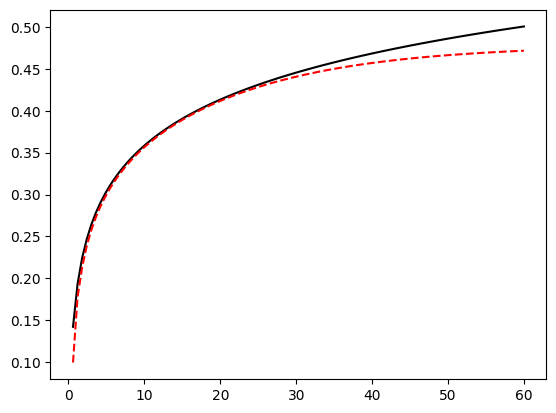

In [9]:
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.6
s=np.zeros(100)
for ik in range(100):
    u=5.0*5.0*0.01/4.0/1.0/t[ik]
    w=-0.5772-np.log(u)
    for jk in range(1,100):
        w=w-((-1.0)**(jk))*(u**jk)/(jk*1.0)/np.math.factorial(jk)
    s[ik]=1.0/4.0/np.pi/1.0*w
plt.plot(t,s,'k-')
s1=np.zeros(100)
ta=1.0; ss=0.01
r0=np.zeros(1000)
r0[0]=0.1
for ik in range(1,1000):
    r0[ik]=ik*1.0
for ik in range(100):
    rkk=5.0; tk=t[ik]
    for jk in range(1,61):
        vk=jk*1.0*np.pi/lk1
        nk=(jk-1)*2
        t_term=np.exp(-vk*vk*ta/ss*tk)
        s1[ik]=s1[ik]+ck[nk+0]*t_term*scipy.special.jv(0,rkk*vk)
        s1[ik]=s1[ik]+ck[nk+1]*t_term*scipy.special.yv(0,rkk*vk)
    s1[ik]=s1[ik]
            
plt.plot(t,52.0-s1,'r--')

In [17]:
#forward calculation for pumping (2D)
from scipy.optimize import least_squares
import numpy as np
import scipy
from scipy import special
from numpy.polynomial.hermite import hermfit,hermval
from numpy.polynomial.polynomial import polyfit 
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

def fun_der1(lk1,lk2,r,q,ta,s,t,r0):
    t_len=len(t); r_len=len(r); ini_len=len(r0)
    rcoe=np.zeros((ini_len+t_len*(r_len),60*4))
    ycoe=np.zeros(ini_len+t_len*(r_len))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,61):
            vk1=jk*1.0*np.pi/lk1
            vk2=jk*1.0*np.pi/lk2
            nk=(jk-1)*4
            rcoe[ik,nk+0]=scipy.special.jv(0,rk*vk1)
            rcoe[ik,nk+1]=scipy.special.yv(0,rk*vk1)
            rcoe[ik,nk+2]=scipy.special.jv(0,rk*vk2)
            rcoe[ik,nk+3]=scipy.special.yv(0,rk*vk2)
        ycoe[ik]=52.0
    
    nk_f=ini_len
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,61):
            vk1=jk*1.0*np.pi/lk1
            vk2=jk*1.0*np.pi/lk2
            nk=(jk-1)*4
            t_term=np.exp(-vk1*vk1*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jvp(0,rk*vk1)*vk1
            rcoe[nk_f,nk+1]=t_term*scipy.special.yvp(0,rk*vk1)*vk1
            t_term=np.exp(-vk2*vk2*ta/s*tk)
            rcoe[nk_f,nk+2]=t_term*scipy.special.jvp(0,rk*vk2)*vk2
            rcoe[nk_f,nk+3]=t_term*scipy.special.yvp(0,rk*vk2)*vk2
        ycoe[nk_f]=+q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]
        for jk in range(1,61):
            vk1=jk*1.0*np.pi/lk1
            vk2=jk*1.0*np.pi/lk2
            nk=(jk-1)*4
            t_term=np.exp(-vk1*vk1*ta/s*tk)
            rcoe[nk_f,nk+0]=t_term*scipy.special.jv(0,rk*vk1)
            rcoe[nk_f,nk+1]=t_term*scipy.special.yv(0,rk*vk1)
            t_term=np.exp(-vk2*vk2*ta/s*tk)
            rcoe[nk_f,nk+2]=t_term*scipy.special.jv(0,rk*vk2)
            rcoe[nk_f,nk+3]=t_term*scipy.special.yv(0,rk*vk2)
        ycoe[nk_f]=52.0
        nk_f=nk_f+1
    
    ck=np.linalg.lstsq(rcoe,ycoe,rcond=None)[0]
    
# Calculate the residual
    resk1=np.zeros(ini_len+t_len*(r_len))
# Initial Condition
    for ik in range(ini_len):
        rk=r0[ik]
        for jk in range(1,61):
            vk1=jk*1.0*np.pi/lk1
            vk2=jk*1.0*np.pi/lk2
            nk=(jk-1)*4
            resk1[ik]=resk1[ik]+ck[nk+0]*scipy.special.jv(0,rk*vk1)
            resk1[ik]=resk1[ik]+ck[nk+1]*scipy.special.yv(0,rk*vk1)
            resk1[ik]=resk1[ik]+ck[nk+2]*scipy.special.jv(0,rk*vk2)
            resk1[ik]=resk1[ik]+ck[nk+3]*scipy.special.yv(0,rk*vk2)
        resk1[ik]=resk1[ik]-52.0
    
    nk_f=ini_len
    
    for ik in range(t_len):
        tk=t[ik]
# Boundary Condition
        rk=r[0]
        for jk in range(1,61):
            vk1=jk*1.0*np.pi/lk1
            vk2=jk*1.0*np.pi/lk2
            nk=(jk-1)*4
            t_term=np.exp(-vk1*vk1*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jvp(0,rk*vk1)*vk1
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yvp(0,rk*vk1)*vk1
            t_term=np.exp(-vk2*vk2*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+2]*t_term*scipy.special.jvp(0,rk*vk2)*vk2
            resk1[nk_f]=resk1[nk_f]+ck[nk+3]*t_term*scipy.special.yvp(0,rk*vk2)*vk2
        resk1[nk_f]=resk1[nk_f]-q/2.0/np.pi/rk/1.0
        nk_f=nk_f+1
        
        rk=r[1]
        for jk in range(1,61):
            vk1=jk*1.0*np.pi/lk1
            vk2=jk*1.0*np.pi/lk2
            nk=(jk-1)*4
            t_term=np.exp(-vk1*vk1*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+0]*t_term*scipy.special.jv(0,rk*vk1)
            resk1[nk_f]=resk1[nk_f]+ck[nk+1]*t_term*scipy.special.yv(0,rk*vk1)
            t_term=np.exp(-vk2*vk2*ta/s*tk)
            resk1[nk_f]=resk1[nk_f]+ck[nk+2]*t_term*scipy.special.jv(0,rk*vk2)
            resk1[nk_f]=resk1[nk_f]+ck[nk+3]*t_term*scipy.special.yv(0,rk*vk2)
        resk1[nk_f]=resk1[nk_f]-52.0
        nk_f=nk_f+1
            
            
    print (sum(resk1*resk1))
    return ck,rcoe,ycoe
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
r=np.zeros(2)
r[0]=0.1; r[1]=1000.0
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.6
lk1=1000.0; lk2=50000.0
[ck,rcoe,ycoe]=fun_der1(lk1,lk2,r,1.0,1.0,0.001,t,r0)

8.473556211490172e-15


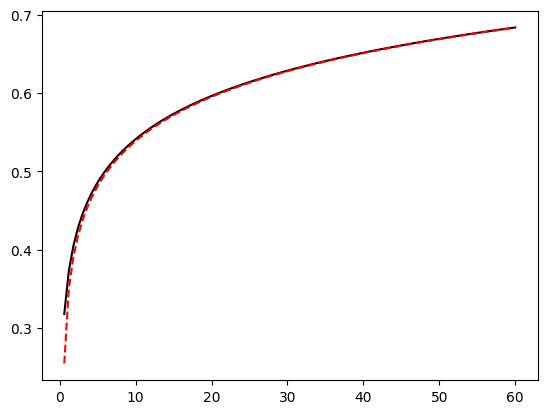

In [18]:
t=np.zeros(100)
for ik in range(100):
    t[ik]=(ik+1)*0.6
s=np.zeros(100)
for ik in range(100):
    u=5.0*5.0*0.001/4.0/1.0/t[ik]
    w=-0.5772-np.log(u)
    for jk in range(1,100):
        w=w-((-1.0)**(jk))*(u**jk)/(jk*1.0)/np.math.factorial(jk)
    s[ik]=1.0/4.0/np.pi/1.0*w
plt.plot(t,s,'k-')
s1=np.zeros(100)
ta=1.0; ss=0.001
r0=np.zeros(1000)
r0[0]=0.15
for ik in range(1,1000):
    r0[ik]=ik*1.0
for ik in range(100):
    rkk=5.0; tk=t[ik]
    for jk in range(1,61):
        vk1=jk*1.0*np.pi/lk1
        vk2=jk*1.0*np.pi/lk2
        nk=(jk-1)*4
        t_term=np.exp(-vk1*vk1*ta/ss*tk)
        s1[ik]=s1[ik]+ck[nk+0]*t_term*scipy.special.jv(0,rkk*vk1)
        s1[ik]=s1[ik]+ck[nk+1]*t_term*scipy.special.yv(0,rkk*vk1)
        t_term=np.exp(-vk2*vk2*ta/ss*tk)
        s1[ik]=s1[ik]+ck[nk+2]*t_term*scipy.special.jv(0,rkk*vk2)
        s1[ik]=s1[ik]+ck[nk+3]*t_term*scipy.special.yv(0,rkk*vk2)
    s1[ik]=s1[ik]
            
plt.plot(t,52.0-s1,'r--')